TODO:
 - Check feasability of the lensing operation on the laptop of students 
 - play with the facres parameter to make faster lensing operations 

# Lensing reconstruction tutorial 


In this notebook we will introduce some basic concepts of the lensing of the CMB.

We will generate some random realisations of the CMB, we will then lens it with a lensing field realisation from a flask simulation ?. 
We will then use plancklens to get an estimate of the lensing field, compute its power spectrum and the biases due to the reconstruction. 



The goal is to see how to generate full sky lensed CMB simulations, play a bit using healpy (compute power spectra, put some beams to remove noise etc)

Then when this is done idea is to see how to build a quadratic estimator for temperature and maybe also polarization
Plot the N0 and N1 bias 
Get a lensing power spectrum estimation

Then do it with real planck data ? Would need to get a RDN0 bias as well as mean field estimates ?
Dig into the parameter file ?


In [1]:
import os
import healpy as hp
import numpy as np

import plancklens
from plancklens.filt import filt_simple, filt_util
from plancklens import utils
from plancklens import qest, qecl, qresp
from plancklens import nhl
from plancklens.n1 import n1
from plancklens.sims import planck2018_sims, phas, maps, cmbs, utils as maps_utils

from os.path import join as opj


# import lenspyx

from matplotlib import pyplot as plt

In [2]:
# Set the PLENS environment variable to somewhere you like (later you can add this in your .bash_profile)
os.environ['PLENS'] = opj(os.environ['HOME'], 'plens')
TEMP =  opj(os.environ['PLENS'], 'tutorial')
# A lot of things will be cached in this TEMP directory.
# If you update some of the parameters afterward, plancklesn will raise some errors with hasckecks. 
# In this case it is safer to update this TEMP directory to be sure to not mess things around


### We start by getting an input power spectrum 
We will use the default one, but any CMB and lensing spectrum from CAMB or CLASS is ok 

In [3]:
cls_path = opj(os.path.dirname(os.path.abspath(plancklens.__file__)), 'data', 'cls')

# Fiducial unlensed and lensed power spectra used for the analysis:
cl_unl = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
cl_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))

In [4]:
def f(ell):
    return ell*(ell+1)

In [27]:
axs.flatten()

array([<AxesSubplot:xlabel='$\\ell$'>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

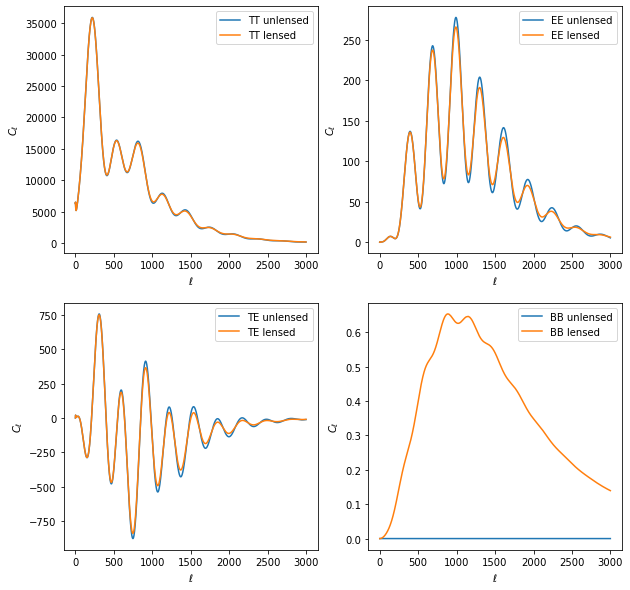

In [31]:
# We can plot them

ell = np.arange(1, 3000)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, key in zip(axs.flatten(), ['tt', 'ee', 'te', 'bb']):
    ax.plot(ell, f(ell)*cl_unl[key][ell], label=f'{key.upper()} unlensed')
    ax.plot(ell, f(ell)*cl_len[key][ell], label=f'{key.upper()} lensed')
    ax.legend()
    ax.set_xlabel(r'$\ell$')

    ax.set_ylabel(r'$C_\ell$')


## Generate a simulation library 
We will generate our own simulations of the lensed CMB in the full sky.
We first need to generate unlensed CMB realization which we will lens it with a realization of the lensing potential field.

The CMB sky are simulated inside a sims_cmb_len object.
This generate alm's drawn from a set of spectra. You can furthermore set the phase of these alms if you wish (useful for tests).
They are lensed using the lenspyx package.

A sim library expects the index -1 to point to the data map: the use of 'sim_lib_shuffle' with the funny dictionary
in the last argument is just a way to define the data map as one of the simulation (outside of the set used for the analysis).


In [6]:
nsims = 10  # Total number of simulations to generate.
lmax_sim = 4096 # lmax to produce the lensed cmb simulations

#--- definition of simulation and inverse-variance filtered simulation libraries:
lmax_ivf = 3000 
lmin_ivf = 2  # We will use in the QE only CMB modes between lmin_ivf and lmax_ivf
lmax_qlm = 4096 # We will calculate lensing estimates until multipole lmax_qlm.
nside = 2048 # Healpix resolution of the data and sims.
nlev_t = 5. # Filtering noise level in temperature (here also used for the noise simulations generation).
nlev_p = 5*np.sqrt(2) # Filtering noise level in polarization (here also used for the noise simulations generation).

beam_fwhm_amin = 2 # Beam full width half maximum in arcminutes




Lensing acts a remapping of the CMB field. It can be defined with a deflection vector $d$

$X(n) = X(n + d(n))$

In [7]:
sims_libdir = opj(TEMP, 'len_alm')
sims = cmbs.sims_cmb_len(sims_libdir, lmax_sim, cl_unl)


In [8]:
# Noise phases

libdir_pixphas = opj(TEMP, 'pix_phas_nside%s'%nside)
pix_phas = phas.pix_lib_phas(libdir_pixphas, 3, (hp.nside2npix(nside),))

In [9]:
# The maps are stored in another object 
# The transfer function is the beam of the instrument and the pixel window 

transf = hp.gauss_beam(beam_fwhm_amin / 60. / 180. * np.pi, lmax=lmax_ivf) * hp.pixwin(nside)[:lmax_ivf + 1]

cmbmaps = maps.cmb_maps_nlev(sims, transf, nlev_t, nlev_p, nside, pix_lib_phas=pix_phas)


## Plot the maps we simulated using healpy 

It can take some time to lens the map when it is generated. After that the map is put in cache so it doesnt need to recompute it.

It is around 4 minutes on the 8 cores of my laptop.... 
Probably not a good idea to make the student compute that on there laptop??

BAND 0 in 16 :
resolve_poles: I have flipped 6 signs out of 12 pixels on north pole
resolve_poles: I have flipped 1 signs out of 1 pixels on south pole
input t1,t2 -0.154 5.832 in degrees
North 9.371 and South 9.365 buffers in amin
cell (theta,phi) in amin (0.938,0.536)
BAND 1 in 16 :
input t1,t2 5.403 11.521 in degrees
North 9.541 and South 9.576 buffers in amin
cell (theta,phi) in amin (0.958,0.527)
BAND 2 in 16 :
input t1,t2 11.041 17.132 in degrees
North 9.520 and South 9.542 buffers in amin
cell (theta,phi) in amin (0.954,0.388)
BAND 3 in 16 :
input t1,t2 16.661 22.756 in degrees
North 9.525 and South 9.518 buffers in amin
cell (theta,phi) in amin (0.955,0.510)
BAND 4 in 16 :
input t1,t2 22.267 28.386 in degrees
North 9.517 and South 9.565 buffers in amin
cell (theta,phi) in amin (0.959,0.627)
BAND 5 in 16 :
input t1,t2 27.867 33.990 in degrees
North 9.581 and South 9.579 buffers in amin
cell (theta,phi) in amin (0.959,0.737)
BAND 6 in 16 :
input t1,t2 33.494 39.656 in degrees
Nor

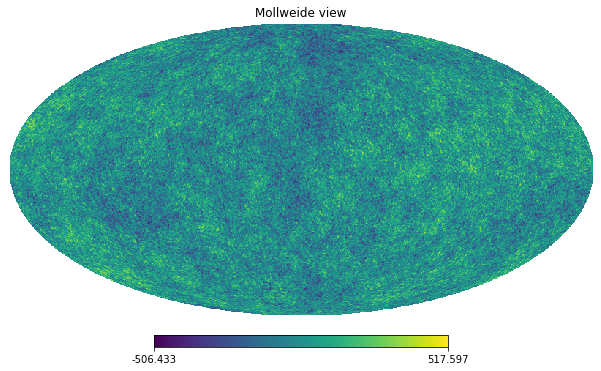

In [10]:
idx = 0
tmap = cmbmaps.get_sim_tmap(idx)
hp.mollview(tmap)

In [11]:
cl_tt_input = hp.anafast(tmap)

In [12]:
def f(ell):
    return ell*(ell+1)

In [13]:
nltt =  (nlev_t / 60. / 180. * np.pi / transf)** 2

[]

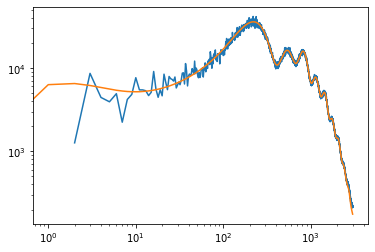

In [14]:
ls_ivf = np.arange(lmin_ivf, lmax_ivf)
# ls = np.arange(1, 5000)
ls = np.arange(lmax_ivf)
plt.plot(ls_ivf, f(ls_ivf)* cl_tt_input[ls_ivf]*utils.cli(transf)[ls_ivf]**2)
# plt.plot(ls, f(ls)* cl_tt_input[ls])

plt.plot(ls, f(ls)*cl_len['tt'][ls])

# plt.plot(ls_ivf, f(ls_ivf)* nltt[ls_ivf])
plt.loglog()
# plt.semilogx()
# plt.ylim(1e2, 5e4)

### Quadratic estimator

We set here the quadratic estimator 

The QE in real space is a product of the inverse variance filtered (IVF) and Wiener filtered (WF) maps.

In [15]:
# --- We turn to the inverse-variance filtering library. In this file we use trivial isotropic filtering,
#     (independent T and Pol. filtering)
ftl = utils.cli(cl_len['tt'][:lmax_ivf + 1] + (nlev_t / 60. / 180. * np.pi / transf) ** 2)
fel = utils.cli(cl_len['ee'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
fbl = utils.cli(cl_len['bb'][:lmax_ivf + 1] + (nlev_p / 60. / 180. * np.pi / transf) ** 2)
ftl[:lmin_ivf] *= 0.
fel[:lmin_ivf] *= 0.
fbl[:lmin_ivf] *= 0.
#: Inverse CMB co-variance in T, E and B (neglecting TE coupling).

ivfs_libdir = opj(TEMP, 'ivfs')
ivfs = filt_simple.library_fullsky_sepTP(ivfs_libdir, cmbmaps, nside, transf, cl_len, ftl, fel, fbl, cache=True)
#: Inverse-variance filtering instance. Here a trivial isotropic inverse variance weighting.


In [32]:
qlms_dd = qest.library_sepTP(opj(TEMP, 'qlms'), ivfs, ivfs,   cl_len['te'], nside, lmax_qlm=lmax_qlm)


In [17]:
cl_weight = utils.camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_weight['bb'] *= 0.
#: CMB spectra entering the QE weights (the spectra multplying the inverse-variance filtered maps in the QE legs)


In [18]:
#---- semi-analytical Gaussian lensing bias library:
nhl_dd = nhl.nhl_lib_simple(os.path.join(TEMP, 'nhl_dd'), ivfs, cl_weight, lmax_qlm)

#---- N1 lensing bias library:
libdir_n1_dd = os.path.join(TEMP, 'n1')
n1_dd = n1.library_n1(libdir_n1_dd,cl_len['tt'],cl_len['te'],cl_len['ee'])

#---- QE response calculation library:
qresp_dd = qresp.resp_lib_simple(os.path.join(TEMP, 'qresp'), lmax_ivf, cl_weight, cl_len,
                                 {'t': ivfs.get_ftl(), 'e':ivfs.get_fel(), 'b':ivfs.get_fbl()}, lmax_qlm)


In [19]:
qe_key = 'ptt'

In [20]:
qlm = qlms_dd.get_sim_qlm('ptt', idx)


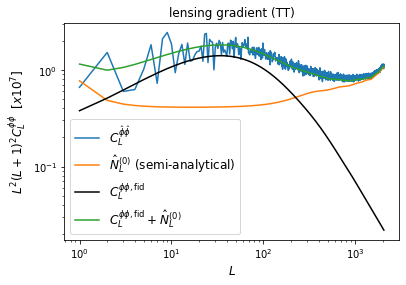

In [21]:
# Lensing response according to the fiducial cosmology:
qresp = qresp_dd.get_response(qe_key, 'p')


# Estimator normalization is the inverse response:
qnorm = utils.cli(qresp)

# Semi-analytical realization-dependent Gaussian noise bias (of the unnormalized estimator):
nhl = nhl_dd.get_sim_nhl(idx, qe_key, qe_key)

# and we plot the normalized resulting spectra:
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 * 0.5 / np.pi * 1e7
ell = np.arange(2 if qe_key[0] == 'x' else 1, 2048)

plt.figure()
plt.title('lensing gradient (TT)' if qe_key[0] == 'p' else 'lensing curl (TT)')
label=r'$C_L^{\hat \phi \hat \phi}$' if qe_key[0] == 'p' else r'$C_L^{\hat \omega \hat \omega}$'
plt.loglog(ell, hp.alm2cl(qlm)[ell] * qnorm[ell] ** 2 / qlms_dd.fsky12 * w(ell), label=label)
plt.loglog(ell, nhl[ell] * qnorm[ell] ** 2 * w(ell), label=r'$\hat N_L^{(0)}$ (semi-analytical)')
plt.loglog(ell, cl_unl['pp'][ell] *  w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
if  qe_key[0] == 'p':
    plt.loglog(ell, (cl_unl['pp'][ell] + nhl[ell] * qnorm[ell] ** 2) *  w(ell), label=r'$C_L^{\phi\phi, \rm fid} + \hat N_L^{(0)}$ ')
plt.xlabel('$L$', fontsize=12)
plt.ylabel('$L^2 (L + 1)^2 C_L^{\phi\phi}$  [$x10^7$]', fontsize=12)
plt.legend(fontsize=12, loc='lower left')

In [22]:
plm_input = utils.alm_copy(sims.get_sim_plm(idx), lmax=lmax_qlm)

[]

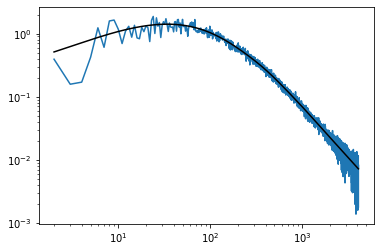

In [23]:
ls = np.arange(2, lmax_qlm+1)
plt.plot(ls, hp.alm2cl(plm_input, qlm)[ls] * qnorm[ls] * w(ls))
plt.loglog(ls, cl_unl['pp'][ls] *  w(ls), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')

plt.loglog()

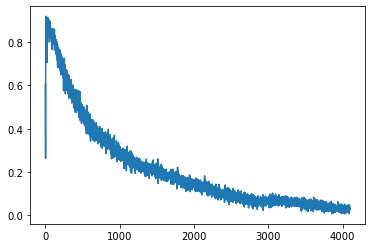

In [24]:
plt.plot(ls, hp.alm2cl(plm_input, qlm)[ls] / np.sqrt(hp.alm2cl(plm_input) * hp.alm2cl(qlm))[ls])
